# Project Prompt

In this project you must create a web service that uses machine learning to make predictions based on the data set powerproduction available on Moodle. The goal is to produce a model that accurately predicts wind turbine power output from wind speed values, as in the data set. You must then develop a web service that will respond with predicted power values based on speed values sent as HTTP requests. Your submission must be in the form of a git repository containing, at a minimum, the following items:
1. Jupyter notebook that trains a model using the data set. In the notebook you should explain your model and give an analysis of its accuracy.
2. Python script that runs a web service based on the model, as above.
3. Dockerfile to build and run the web service in a container.
4. Standard items in a git repository such as a README.
To enhance your submission, you might consider developing and comparing more than one model. Rest assured, all the above concepts will be explored in lecture videos and other materials in the coming semester.


# Approach




In [1]:
# Neural networks.
import tensorflow.keras as kr

# to split data into training and testing sets
from sklearn.model_selection import train_test_split

# for evaluating models
from sklearn import metrics

# Numerical arrays
import numpy as np

# Data frames.
import pandas as pd

# Plotting
import matplotlib.pyplot as plt

# Plot style.
plt.style.use("ggplot")

# Make matplotlib show interactive plots in the notebook.
%matplotlib inline

# Plot size.
plt.rcParams['figure.figsize'] = [14, 8]

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/ianmcloughlin/2020A-machstat-project/master/dataset/powerproduction.csv')
# the first and last few rows have power values of zero, so we increase the number displayed
pd.set_option('display.min_rows', 30)
df

,speed,power
0,0.000,0.000
1,0.125,0.000
2,0.150,0.000
3,0.225,0.000
4,0.275,0.000
5,0.325,4.331
6,0.400,5.186
7,0.450,3.826
8,0.501,1.048
9,0.526,5.553


Text(0, 0.5, 'power')

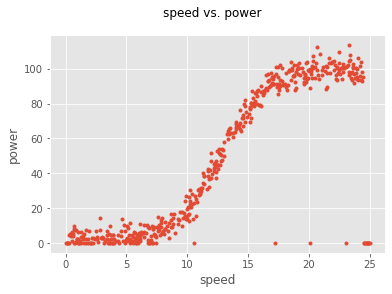

In [3]:
columns = df.columns
plt.plot(df[columns[0]], df[columns[1]], '.')
plt.suptitle(f'{columns[0]} vs. {columns[1]}')
plt.xlabel(f'{columns[0]}')
plt.ylabel(f'{columns[1]}')

We can immediately see that we are dealing with a [Sigmoid-like function](https://en.wikipedia.org/wiki/Sigmoid_function):



<img src="https://upload.wikimedia.org/wikipedia/commons/8/88/Logistic-curve.svg" width="400" height="500" align="left">

<br><br><br><br><br><br><br><br><br><br><br><br><br><br>

However, more relevant to our purpose is the even more basic fact that there is clearly a very strong relationship between speed and power, although it not linear but quadratic. The other important thing to notice is that there are a clear number of outliers in the sample where speed is relatively high but power is 0, and in particular, the last 10 points in the sample have power of zero, even though they have a very high speed value. Because these points clearly are not typical outliers in the sense that they all have the same y value and are so far from what we would expect them to be, there are really only three interpretations of their values:

1. They were incorrectly measured (perhaps the power values simply weren't recorded, and thus were entered as zero.

2. They values are accurate, and are explained by an external influence that over-rided the relationship between speed and power (e.g. perhaps their was no capacity on those days to store the electricity generated, so despite high speeds zero power was generated).

3. For speeds higher than a certain value, power is always zero.

Although the repeated zero values for power for the last ten points of the sample is suspicious, the most responsible response to these zero values would likely be to first include then as legitimate values, analyze their effect on the models, and then decide from there whether how to deal with them. For that reason I will not (at least a first) shed the sample of those points where speed is high but power is zero.



## 

In [4]:
# Create a neural network with one neuron.
model = kr.models.Sequential()
model.add(kr.layers.Dense(50, input_shape=(1,), activation="sigmoid", kernel_initializer='ones', bias_initializer='zeros'))
model.add(kr.layers.Dense(1, input_shape=(1,), activation="linear", kernel_initializer='ones', bias_initializer='zeros'))
model.compile(kr.optimizers.Adam(lr=0.0095), loss='mean_squared_error')

In [5]:
# split the dataset into training and testing data
# see here: https://realpython.com/train-test-split-python-data/
x_train, x_test, y_train, y_test = train_test_split(df[columns[0]][:490], df[columns[1]][:490], test_size=0.3)

In [6]:
# Train the neural network on our training data.
model.fit(x_train, y_train, epochs=500)

Epoch 1/500
11/11 [==============================] - 0s 1ms/step - loss: 1601.0256
Epoch 2/500
11/11 [==============================] - 0s 1ms/step - loss: 1569.2013
Epoch 3/500
11/11 [==============================] - 0s 1ms/step - loss: 1528.9740
Epoch 4/500
11/11 [==============================] - 0s 1ms/step - loss: 1480.4591
Epoch 5/500
11/11 [==============================] - 0s 2ms/step - loss: 1396.4481
Epoch 6/500
11/11 [==============================] - 0s 1ms/step - loss: 1220.6960
Epoch 7/500
11/11 [==============================] - 0s 1ms/step - loss: 1006.6067
Epoch 8/500
11/11 [==============================] - 0s 2ms/step - loss: 900.0943
Epoch 9/500
11/11 [==============================] - 0s 2ms/step - loss: 809.5026
Epoch 10/500
11/11 [==============================] - 0s 1ms/step - loss: 726.9711
Epoch 11/500
11/11 [==============================] - 0s 1ms/step - loss: 660.2854
Epoch 12/500
11/11 [==============================] - 0s 2ms/step - loss: 603.7986
Epoch 

11/11 [==============================] - 0s 1ms/step - loss: 87.1112
Epoch 100/500
11/11 [==============================] - 0s 1ms/step - loss: 86.7681
Epoch 101/500
11/11 [==============================] - 0s 1ms/step - loss: 86.5798
Epoch 102/500
11/11 [==============================] - 0s 1ms/step - loss: 86.6057
Epoch 103/500
11/11 [==============================] - 0s 1ms/step - loss: 85.8343
Epoch 104/500
11/11 [==============================] - 0s 1ms/step - loss: 86.6616
Epoch 105/500
11/11 [==============================] - 0s 1ms/step - loss: 85.5470
Epoch 106/500
11/11 [==============================] - 0s 1ms/step - loss: 85.6948
Epoch 107/500
11/11 [==============================] - 0s 1ms/step - loss: 87.1942
Epoch 108/500
11/11 [==============================] - 0s 1ms/step - loss: 86.5323
Epoch 109/500
11/11 [==============================] - 0s 1ms/step - loss: 87.9344
Epoch 110/500
11/11 [==============================] - 0s 1ms/step - loss: 87.6829
Epoch 111/500
11/1

11/11 [==============================] - 0s 2ms/step - loss: 77.2678
Epoch 198/500
11/11 [==============================] - 0s 2ms/step - loss: 77.7966
Epoch 199/500
11/11 [==============================] - 0s 2ms/step - loss: 77.3934
Epoch 200/500
11/11 [==============================] - 0s 1ms/step - loss: 77.1191
Epoch 201/500
11/11 [==============================] - 0s 1ms/step - loss: 77.3015
Epoch 202/500
11/11 [==============================] - 0s 1ms/step - loss: 77.3864
Epoch 203/500
11/11 [==============================] - 0s 1ms/step - loss: 77.0127
Epoch 204/500
11/11 [==============================] - 0s 997us/step - loss: 77.8825
Epoch 205/500
11/11 [==============================] - 0s 1ms/step - loss: 77.6846
Epoch 206/500
11/11 [==============================] - 0s 1ms/step - loss: 76.7285
Epoch 207/500
11/11 [==============================] - 0s 1ms/step - loss: 77.0930
Epoch 208/500
11/11 [==============================] - 0s 1ms/step - loss: 77.9059
Epoch 209/500
11

11/11 [==============================] - 0s 1ms/step - loss: 73.5048
Epoch 296/500
11/11 [==============================] - 0s 1ms/step - loss: 73.5906
Epoch 297/500
11/11 [==============================] - 0s 2ms/step - loss: 73.5158
Epoch 298/500
11/11 [==============================] - 0s 2ms/step - loss: 73.4259
Epoch 299/500
11/11 [==============================] - 0s 1ms/step - loss: 73.6297
Epoch 300/500
11/11 [==============================] - 0s 1ms/step - loss: 74.2776
Epoch 301/500
11/11 [==============================] - 0s 1ms/step - loss: 74.7767
Epoch 302/500
11/11 [==============================] - 0s 1ms/step - loss: 73.1491
Epoch 303/500
11/11 [==============================] - 0s 1ms/step - loss: 73.8737
Epoch 304/500
11/11 [==============================] - 0s 1ms/step - loss: 74.1841
Epoch 305/500
11/11 [==============================] - 0s 1ms/step - loss: 74.5140
Epoch 306/500
11/11 [==============================] - 0s 1ms/step - loss: 74.9514
Epoch 307/500
11/1

11/11 [==============================] - 0s 2ms/step - loss: 72.6786
Epoch 394/500
11/11 [==============================] - 0s 2ms/step - loss: 73.7355
Epoch 395/500
11/11 [==============================] - 0s 2ms/step - loss: 73.1465
Epoch 396/500
11/11 [==============================] - 0s 2ms/step - loss: 73.5834
Epoch 397/500
11/11 [==============================] - 0s 1ms/step - loss: 72.3072
Epoch 398/500
11/11 [==============================] - 0s 2ms/step - loss: 72.2622
Epoch 399/500
11/11 [==============================] - 0s 1ms/step - loss: 71.6594
Epoch 400/500
11/11 [==============================] - 0s 1ms/step - loss: 71.9116
Epoch 401/500
11/11 [==============================] - 0s 1ms/step - loss: 71.8865
Epoch 402/500
11/11 [==============================] - 0s 1ms/step - loss: 71.8575
Epoch 403/500
11/11 [==============================] - 0s 1ms/step - loss: 72.1586
Epoch 404/500
11/11 [==============================] - 0s 2ms/step - loss: 71.6782
Epoch 405/500
11/1

11/11 [==============================] - 0s 1ms/step - loss: 71.3018
Epoch 492/500
11/11 [==============================] - 0s 1ms/step - loss: 71.5472
Epoch 493/500
11/11 [==============================] - 0s 2ms/step - loss: 71.4895
Epoch 494/500
11/11 [==============================] - 0s 1ms/step - loss: 71.2605
Epoch 495/500
11/11 [==============================] - 0s 1ms/step - loss: 71.2673
Epoch 496/500
11/11 [==============================] - 0s 1ms/step - loss: 72.2003
Epoch 497/500
11/11 [==============================] - 0s 1ms/step - loss: 74.4473
Epoch 498/500
11/11 [==============================] - 0s 1ms/step - loss: 71.4941
Epoch 499/500
11/11 [==============================] - 0s 2ms/step - loss: 71.5247
Epoch 500/500
11/11 [==============================] - 0s 1ms/step - loss: 71.6987


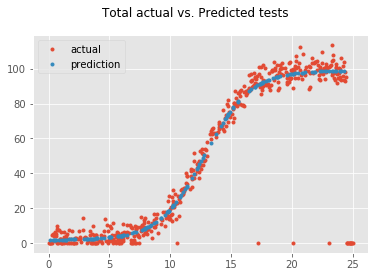

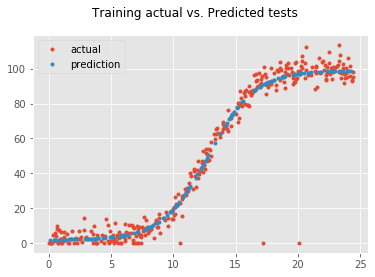

In [7]:
# Now let's see.
plt.plot(df[columns[0]], df[columns[1]], '.', label='actual')
plt.plot(x_test, model.predict(x_test), '.', label='prediction')
plt.suptitle("Total actual vs. Predicted tests")
plt.legend()
plt.show()

# Now let's see.
plt.plot(x_train, y_train, '.', label='actual')
plt.plot(x_test, model.predict(x_test), '.', label='prediction')
plt.suptitle("Training actual vs. Predicted tests")
plt.legend()
plt.show()

In [8]:
predictions = model.predict(x_test)

print("Root mean squared error:")
print(metrics.mean_squared_error(y_test, predictions))

Root mean squared error:
82.21840271893325


Our model has a root mean square error of almost 100 when operating on our training set, it has a lower error value of around 20 on our testing set. This is a good indication that we haven't overfitted our model. What is interesting is for values of speed greater than around 16, our model appears to consistently underestimate power. This is possibly due to thethree data points that have speed values of greater than 16 but power values of zero. If we remove those values from the dataset, we will likely get a 'better fitting' model. We can try this now, although even if we arrive at a better model, the removal of those anomolous data points is still not likely justified, as they may indeed be legimitate values that will simply be intractable for a model that only looks as speed and power

In [9]:
newDF = df.loc[(df['speed']<16) | (df['power']!=0)]
newDF

,speed,power
0,0.000,0.000
1,0.125,0.000
2,0.150,0.000
3,0.225,0.000
4,0.275,0.000
5,0.325,4.331
6,0.400,5.186
7,0.450,3.826
8,0.501,1.048
9,0.526,5.553


In [10]:
# split the dataset into training and testing data
# see here: https://realpython.com/train-test-split-python-data/
x_train, x_test, y_train, y_test = train_test_split(newDF[columns[0]], newDF[columns[1]], test_size=0.3)

In [11]:
# Train the neural network on our training data.
model.fit(x_train, y_train, epochs=500)

Epoch 1/500
11/11 [==============================] - 0s 1ms/step - loss: 20.5192
Epoch 2/500
11/11 [==============================] - 0s 1ms/step - loss: 19.5219
Epoch 3/500
11/11 [==============================] - 0s 1ms/step - loss: 19.2493
Epoch 4/500
11/11 [==============================] - 0s 1ms/step - loss: 19.2928
Epoch 5/500
11/11 [==============================] - 0s 1ms/step - loss: 19.2987
Epoch 6/500
11/11 [==============================] - 0s 2ms/step - loss: 19.4692
Epoch 7/500
11/11 [==============================] - 0s 1ms/step - loss: 19.5772
Epoch 8/500
11/11 [==============================] - 0s 1ms/step - loss: 19.2443
Epoch 9/500
11/11 [==============================] - 0s 1ms/step - loss: 19.5505
Epoch 10/500
11/11 [==============================] - 0s 2ms/step - loss: 19.2850
Epoch 11/500
11/11 [==============================] - 0s 1ms/step - loss: 19.2966
Epoch 12/500
11/11 [==============================] - 0s 2ms/step - loss: 19.2658
Epoch 13/500
11/11 [=====

11/11 [==============================] - 0s 1ms/step - loss: 19.3733
Epoch 102/500
11/11 [==============================] - 0s 1ms/step - loss: 19.4204
Epoch 103/500
11/11 [==============================] - 0s 1ms/step - loss: 20.5399
Epoch 104/500
11/11 [==============================] - 0s 1ms/step - loss: 21.1561
Epoch 105/500
11/11 [==============================] - 0s 1ms/step - loss: 19.9196
Epoch 106/500
11/11 [==============================] - 0s 1ms/step - loss: 19.7864
Epoch 107/500
11/11 [==============================] - 0s 1ms/step - loss: 19.9353
Epoch 108/500
11/11 [==============================] - 0s 1ms/step - loss: 21.0709
Epoch 109/500
11/11 [==============================] - 0s 1ms/step - loss: 19.4548
Epoch 110/500
11/11 [==============================] - 0s 1ms/step - loss: 19.3991
Epoch 111/500
11/11 [==============================] - 0s 1ms/step - loss: 19.8135
Epoch 112/500
11/11 [==============================] - 0s 1ms/step - loss: 19.7305
Epoch 113/500
11/1

11/11 [==============================] - 0s 2ms/step - loss: 19.3926
Epoch 200/500
11/11 [==============================] - 0s 2ms/step - loss: 19.4110
Epoch 201/500
11/11 [==============================] - 0s 2ms/step - loss: 20.3192
Epoch 202/500
11/11 [==============================] - 0s 1ms/step - loss: 19.5316
Epoch 203/500
11/11 [==============================] - 0s 2ms/step - loss: 19.3610
Epoch 204/500
11/11 [==============================] - 0s 2ms/step - loss: 19.4738
Epoch 205/500
11/11 [==============================] - 0s 2ms/step - loss: 19.0938
Epoch 206/500
11/11 [==============================] - 0s 1ms/step - loss: 19.1471
Epoch 207/500
11/11 [==============================] - 0s 1ms/step - loss: 19.5904
Epoch 208/500
11/11 [==============================] - 0s 2ms/step - loss: 19.7159
Epoch 209/500
11/11 [==============================] - 0s 2ms/step - loss: 19.1752
Epoch 210/500
11/11 [==============================] - 0s 1ms/step - loss: 19.1576
Epoch 211/500
11/1

11/11 [==============================] - 0s 2ms/step - loss: 19.3198
Epoch 298/500
11/11 [==============================] - 0s 2ms/step - loss: 19.6036
Epoch 299/500
11/11 [==============================] - 0s 1ms/step - loss: 19.5247
Epoch 300/500
11/11 [==============================] - 0s 1ms/step - loss: 19.0244
Epoch 301/500
11/11 [==============================] - 0s 1ms/step - loss: 19.3747
Epoch 302/500
11/11 [==============================] - 0s 1ms/step - loss: 19.3658
Epoch 303/500
11/11 [==============================] - 0s 2ms/step - loss: 18.9721
Epoch 304/500
11/11 [==============================] - 0s 2ms/step - loss: 19.6345
Epoch 305/500
11/11 [==============================] - 0s 1ms/step - loss: 19.2138
Epoch 306/500
11/11 [==============================] - 0s 2ms/step - loss: 19.0629
Epoch 307/500
11/11 [==============================] - 0s 1ms/step - loss: 19.6157
Epoch 308/500
11/11 [==============================] - 0s 2ms/step - loss: 19.4689
Epoch 309/500
11/1

11/11 [==============================] - 0s 2ms/step - loss: 21.0321
Epoch 396/500
11/11 [==============================] - 0s 2ms/step - loss: 20.0296
Epoch 397/500
11/11 [==============================] - ETA: 0s - loss: 18.63 - 0s 1ms/step - loss: 19.3285
Epoch 398/500
11/11 [==============================] - 0s 2ms/step - loss: 19.3573
Epoch 399/500
11/11 [==============================] - 0s 2ms/step - loss: 19.2890
Epoch 400/500
11/11 [==============================] - 0s 1ms/step - loss: 19.0985
Epoch 401/500
11/11 [==============================] - 0s 2ms/step - loss: 19.2066
Epoch 402/500
11/11 [==============================] - 0s 2ms/step - loss: 19.3254
Epoch 403/500
11/11 [==============================] - 0s 2ms/step - loss: 19.7002
Epoch 404/500
11/11 [==============================] - 0s 2ms/step - loss: 20.1547
Epoch 405/500
11/11 [==============================] - 0s 1ms/step - loss: 19.1227
Epoch 406/500
11/11 [==============================] - 0s 2ms/step - loss: 20

11/11 [==============================] - 0s 2ms/step - loss: 19.4507
Epoch 494/500
11/11 [==============================] - 0s 1ms/step - loss: 18.8238
Epoch 495/500
11/11 [==============================] - 0s 1ms/step - loss: 19.4057
Epoch 496/500
11/11 [==============================] - 0s 1ms/step - loss: 18.9543
Epoch 497/500
11/11 [==============================] - 0s 2ms/step - loss: 19.5643
Epoch 498/500
11/11 [==============================] - 0s 2ms/step - loss: 19.1909
Epoch 499/500
11/11 [==============================] - 0s 1ms/step - loss: 19.1404
Epoch 500/500
11/11 [==============================] - 0s 2ms/step - loss: 19.4384


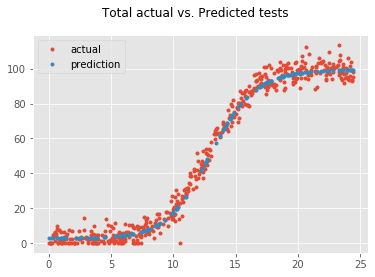

In [12]:
# Now let's see.
plt.plot(newDF[columns[0]], newDF[columns[1]], '.', label='actual')
plt.plot(x_test, model.predict(x_test), '.', label='prediction')
plt.suptitle("Total actual vs. Predicted tests")
plt.legend()
plt.show()

In [13]:
predictions = model.predict(x_test)

print("Root mean squared error:")
print(metrics.mean_squared_error(y_test, predictions))

Root mean squared error:
16.006616033062745


On this occasion, the loss on the training set is much less, and the testing set has similar levels of loss. If we look at the graph, the underestimating of power when speed is greater than 16 has mostly disappeared. We thus appear to have a better model, but only if we assume that the zero-power points we removed were illegitimate measurements, and that does not appear to be a legitimate assumption.

In [15]:
model.predict([[100]])

array([[99.673134]], dtype=float32)

In [17]:
float("-21")

-21.0